# Tweet Sentiment Analysis Model Training

### Import required libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns

In [2]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [4]:
import joblib

In [5]:
# Download NLTK resources
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to C:\Users\Yassine
[nltk_data]     Darif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\Yassine
[nltk_data]     Darif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Yassine
[nltk_data]     Darif\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Data Loading

In [6]:
# Read dataset
sentiment_df = pd.read_csv('data/all-data.csv')  

# Display the first 5 rows of the DataFrame
display(sentiment_df.head())

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
# Data shape
sentiment_df.shape

(75682, 4)

In [8]:
# Assign column names to DataFrame
sentiment_df.columns = ['id', 'entity', 'sentiment', 'text']

In [9]:
# Select relevant colomnes
sentiment_df = sentiment_df[["text", "sentiment"]]

In [10]:
# Convert 'Irrelevant' to 'Neutral'
sentiment_df["sentiment"] = sentiment_df["sentiment"].replace("Irrelevant", "Neutral")

### Exploratory Data Analysis (EDA)

In [11]:
# Show first rows
display(sentiment_df.head())

,text,sentiment
0,im getting on borderlands and i will murder yo...,Positive
1,I am coming to the borders and I will kill you...,Positive
2,im getting on borderlands and i will kill you ...,Positive
3,im coming on borderlands and i will murder you...,Positive
4,im getting on borderlands 2 and i will murder ...,Positive


In [12]:
# Show the last 5 rows of the dataset
display(sentiment_df.tail())

,text,sentiment
75677,⭐️ Toronto is the arts and culture capital of ...,Neutral
75678,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,Neutral
75679,Today sucked so it’s time to drink wine n play...,Positive
75680,Bought a fraction of Microsoft today. Small wins.,Positive
75681,Johnson & Johnson to stop selling talc baby po...,Neutral


In [13]:
# General info
print(sentiment_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75682 entries, 0 to 75681
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       74996 non-null  object
 1   sentiment  75682 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB
None


In [14]:
# Basic statistics
print(sentiment_df.describe())

         text sentiment
count   74996     75682
unique  69974         3
top             Neutral
freq      172     31765


In [15]:
# Check missing values
print(sentiment_df.isnull().sum())

text         686
sentiment      0
dtype: int64


In [16]:
# Check duplicates
print(sentiment_df.duplicated().sum())

5501


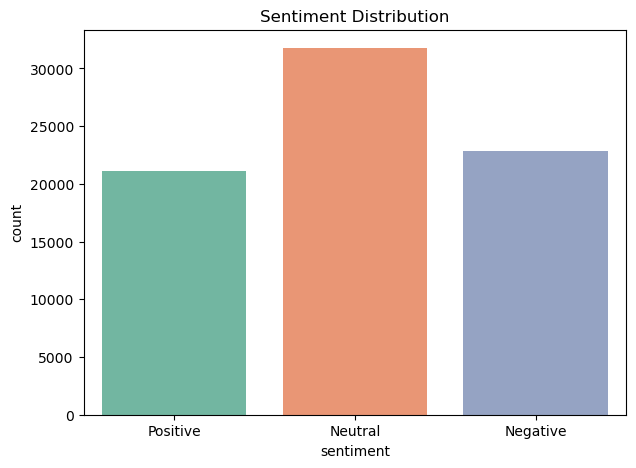

In [17]:
# Sentiment distribution - barplot
plt.figure(figsize=(7,5))
sns.countplot(data=sentiment_df, x='sentiment', palette='Set2', hue='sentiment')
plt.title("Sentiment Distribution")
plt.show()

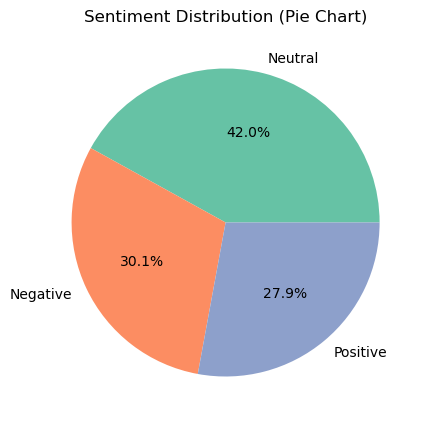

In [18]:
# Sentiment distribution - pie chart
sizes = sentiment_df['sentiment'].value_counts()
labels = sizes.index
colors = sns.color_palette("Set2")

plt.figure(figsize=(5,5))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors)
plt.title("Sentiment Distribution (Pie Chart)")
plt.show()

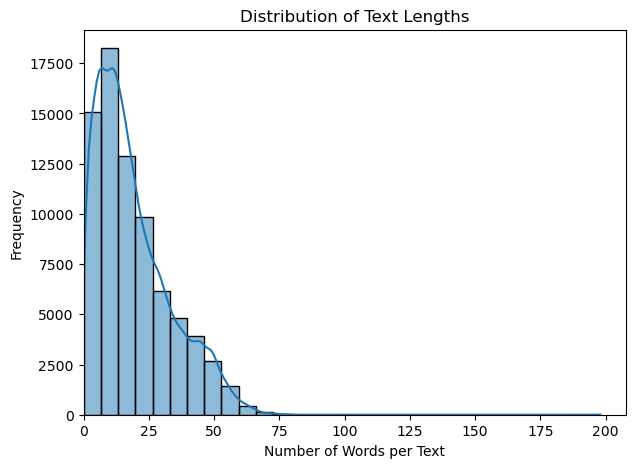

In [19]:
# Text length analysis
sentiment_df["text_length"] = sentiment_df["text"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(7,5))
sns.histplot(sentiment_df["text_length"], bins=30, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of Words per Text")
plt.ylabel("Frequency")
plt.xlim(left=0)
plt.show()

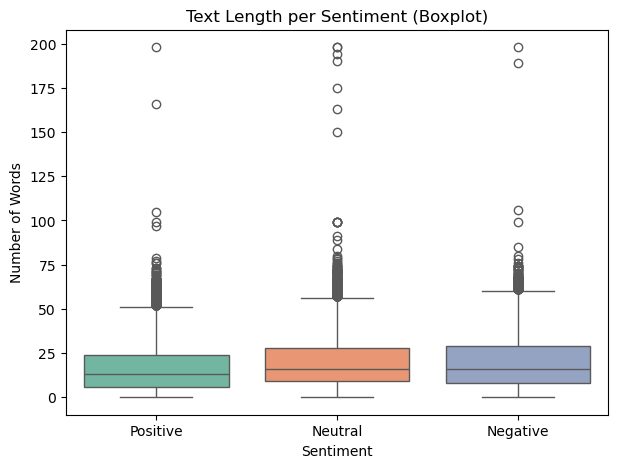

In [20]:
plt.figure(figsize=(7,5))
sns.boxplot(data=sentiment_df, x='sentiment', y='text_length', palette='Set2', hue="sentiment")
plt.title("Text Length per Sentiment (Boxplot)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Words")
plt.show()

### Data Cleaning & Preprocessing

In [21]:
# Delete rows that have null values
sentiment_df = sentiment_df.dropna()

In [22]:
# Check missing values
print(sentiment_df.isnull().sum())

text           0
sentiment      0
text_length    0
dtype: int64


In [23]:
# Remove fully duplicated rows
sentiment_df = sentiment_df.drop_duplicates()

In [24]:
# Check duplicates
print(sentiment_df.duplicated().sum())

0


In [25]:
# Text cleaning
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    # text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)  # Remove URLs
    # text = re.sub(r'\@\w+|\#','', text)  # Remove mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

sentiment_df['cleaned_text'] = sentiment_df['text'].apply(clean_text)

In [26]:
# Tokenization, stopwords removal, lemmatization
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
stemmer    = PorterStemmer()

negations = negations = {"no", "not", "nor", "never"}
stop_words = stop_words - negations  # retire ces mots de la liste à supprimer

def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    # tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

sentiment_df['processed_text'] = sentiment_df['cleaned_text'].apply(preprocess_text)

In [27]:
if "not" in stop_words:
    print("t")

In [28]:
sentiment_df[['text','cleaned_text','processed_text']].tail()

,text,cleaned_text,processed_text
75670,♥️ Suikoden 2\n1️⃣ Alex Kidd in Miracle World\...,suikoden alex kidd in miracle world persona so...,suikoden alex kidd miracle world persona soul ...
75671,Thank you to Matching funds Home Depot RW paym...,thank you to matching funds home depot rw paym...,thank matching fund home depot rw payment gene...
75673,Late night stream with the boys! Come watch so...,late night stream with the boys come watch som...,late night stream boy come watch warzone run s...
75677,⭐️ Toronto is the arts and culture capital of ...,toronto is the arts and culture capital of can...,toronto art culture capital canada no wonder w...
75678,tHIS IS ACTUALLY A GOOD MOVE TOT BRING MORE VI...,this is actually a good move tot bring more vi...,actually good move tot bring viewer one people...


In [ ]:
# Function to generate word cloud
def plot_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(text))
    plt.figure(figsize=(8,5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

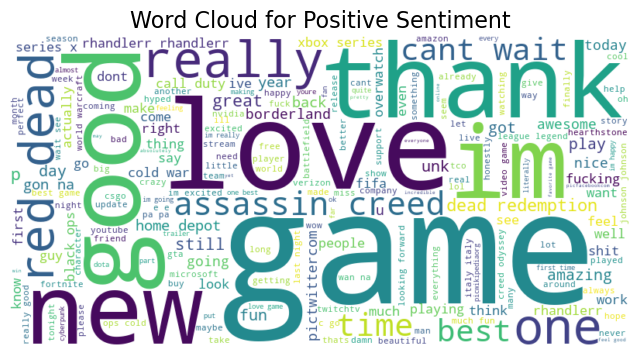

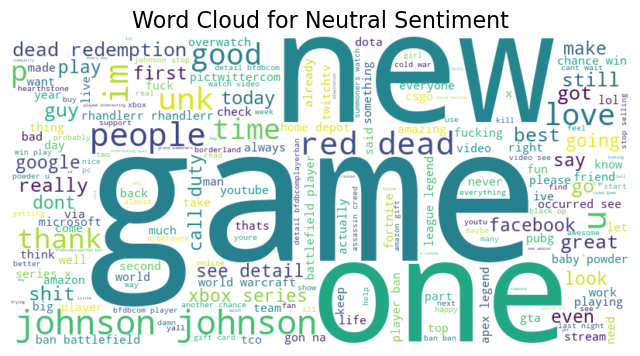

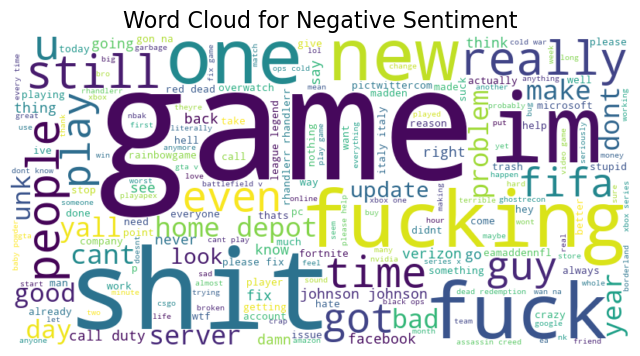

In [86]:
# Generate word clouds for each sentiment
for sentiment in sentiment_df['sentiment'].unique():
    subset = sentiment_df[sentiment_df['sentiment'] == sentiment]['processed_text']
    plot_wordcloud(subset, f'Word Cloud for {sentiment} Sentiment')

In [29]:
# Encode the sentiment column

# Extract the sentiment column
y = sentiment_df['sentiment']

# Initialize the label encoder
le = LabelEncoder()

# Transform the text labels into numeric values
sentiment_df['sentiment_encoded'] = le.fit_transform(y)

# Display the mapping between text labels and numeric codes
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Sentiment label mapping:", label_mapping)

Sentiment label mapping: {'Negative': np.int64(0), 'Neutral': np.int64(1), 'Positive': np.int64(2)}


### Data Splitting

In [30]:
# Selecting a feature and target columns
X = sentiment_df['processed_text']
y = sentiment_df['sentiment_encoded']

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=2
)

### Model Training

In [32]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2))),
    ('model', LogisticRegression(max_iter=1000))
])

In [33]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidf', TfidfVectorizer(ngram_range=(1, 2))),
                ('model', LogisticRegression(max_iter=1000))])

### Model Evaluation

Accuracy: 0.89

Classification Report:
              precision    recall  f1-score   support

    Negative       0.90      0.89      0.89      4266
     Neutral       0.88      0.92      0.90      5916
    Positive       0.90      0.83      0.87      3854

    accuracy                           0.89     14036
   macro avg       0.89      0.88      0.88     14036
weighted avg       0.89      0.89      0.89     14036



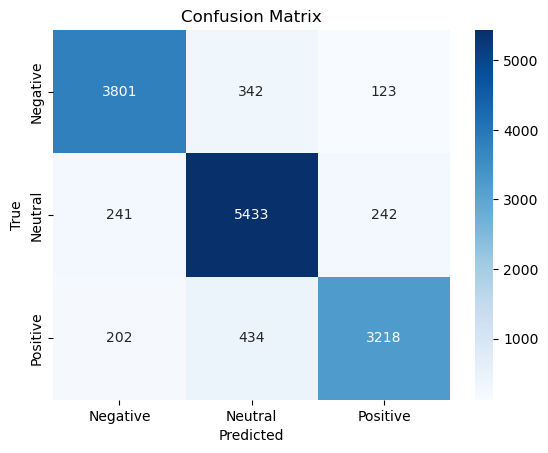

In [34]:
# Prédictions
y_pred = pipeline.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Rapport détaillé
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Model Saving

In [36]:
joblib.dump(pipeline, 'sentiment_model.pkl')
print("Model saved as 'sentiment_model.pkl'")

Model saved as 'sentiment_model.pkl'


### Model Testing

In [37]:
loaded_model = joblib.load('sentiment_model.pkl')
print("Model loaded successfully")

Model loaded successfully


In [38]:
new_tweet = [input("Enter a Tweet: ")]
prediction = loaded_model.predict(new_tweet)
prediction[0]

if prediction[0]   == 0:
    print("Negative Tweet")
elif prediction[0] == 1:
    print("Neutral Tweet")
else:
    print("Positive Tweet")

Enter a Tweet:  I hate waiting so long for my order.


Negative Tweet
